# Add HoroPCA, Tangent PCA
> Add HoroPCA whitening, Tangent PCA to the dataset (developing preprocessing pipeline for benchmarks)

In [2]:
%load_ext autoreload
%autoreload 2

## HoroPCA

In [3]:
# Load HoroPCA - I made a lot of edits to the import structure of HoroPCA
# because it was bad, and fixed some of the imports as well

# from horopca.learning.pca import HoroPCA
from HoroPCA.learning.pca import HoroPCA


In [4]:
hpca = HoroPCA(dim=2, n_components=2)


In [5]:
# Check that horopca.data.center works

import anndata
import numpy as np
import torch
import matplotlib.pyplot as plt

from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.learning.frechet_mean import FrechetMean

from HoroPCA.utils.data import center

adata = anndata.read_h5ad("data/big_table_with_embeddings.h5ad")

# Get our embedding
X_embed = adata.obsm["poi_mix_2"]

# Center
X_embed_tensor = torch.tensor(X_embed)
X_embed_centered = center(X_embed_tensor, lr=1e-1).numpy()

# Check that the mean is 0
print(np.mean(X_embed_centered, axis=0))

# Check that distances are preserved
poincare_ball = Hyperbolic(dim=2, default_coords_type="ball")
indices = np.random.randint(0, X_embed.shape[0], 20)
X_sample = X_embed[indices]
X_sample_centered = X_embed_centered[indices]

dists_embed = np.array(
    [poincare_ball.metric.dist(x, y) for x in X_sample for y in X_sample]
).reshape(20, 20)
dists_embed_centered = np.array(
    [
        poincare_ball.metric.dist(x, y)
        for x in X_sample_centered
        for y in X_sample_centered
    ]
).reshape(20, 20)
diffs = dists_embed - dists_embed_centered

print("Differences between dists (should be zero):")
print("Min:", np.min(diffs), "Max:", np.max(diffs))
print()


INFO: Using numpy backend


[-0.01921776 -0.00957909]
Differences between dists (should be zero):
Min: -7.993605777301127e-15 Max: 1.4210854715202004e-14



In [6]:
def compute_horopca(X, max_samples=1000, lr=1e-1):
    # Coerce to tensor, center
    X = torch.tensor(X, dtype=torch.float32)
    n_samples, n_dim = X.shape
    if n_samples > max_samples:
        X = X[torch.randperm(n_samples)[:max_samples], :]
    X_centered = center(X, lr=lr)

    # Init, fit HoroPCA object; transform data
    horopca = HoroPCA(dim=n_dim, n_components=n_dim, hyperboloid=False)
    horopca.fit(X_centered)
    X_transformed = horopca.project(X_centered)

    return X_transformed.detach().numpy(), horopca


X_hpca, horopca_fitted = compute_horopca(adata.obsm["poi_mix_2"])


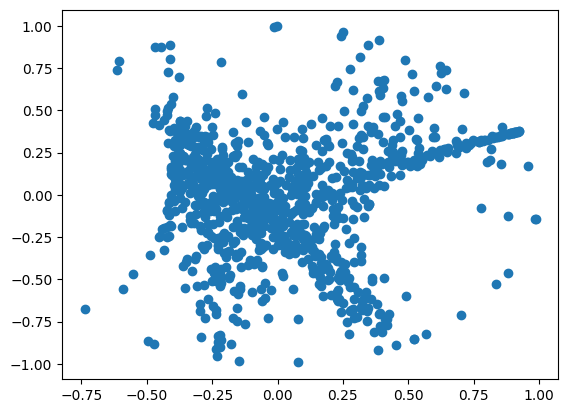

In [7]:
plt.scatter(X_hpca[:, 0], X_hpca[:, 1])


In [8]:
# Whitening function
from HoroPCA.geom.horo import busemann
from sklearn.preprocessing import StandardScaler


def whiten(X, fitted_horopca_object):
    """
    Whiten data with HoroPCA:
    1. Calculate Buseman coordinates
    2. Normalize Buseman coordinates
    """

    # Coerce X to torch tensor
    X = torch.tensor(X, dtype=torch.float32)

    # Calculate Busemann coordinates
    busemann_coords = np.zeros(X.shape)  # assume n_dim = n_components
    for i, x in enumerate(X):
        for j, component in enumerate(fitted_horopca_object.components):
            busemann_coords[i, j] = busemann(x, component)

    # Normalize Busemann coordinates
    scaler = StandardScaler()
    busemann_coords_scaled = scaler.fit_transform(busemann_coords)

    return busemann_coords_scaled


whiten(X_hpca, horopca_fitted)


array([[-0.36382657,  0.22662868],
       [-0.11944745, -0.67744443],
       [-0.22407475, -0.78697125],
       ...,
       [-0.59142393, -0.11418822],
       [ 0.5903411 , -0.16687169],
       [-0.61302966, -0.351594  ]])

In [9]:
def fit_whiten(X, max_samples=1000, lr=1e-1):
    X_horopca, fitted_horopca = compute_horopca(
        X, max_samples=max_samples, lr=lr
    )
    X_whitened = whiten(X_horopca, fitted_horopca)
    return X_whitened


fit_whiten(adata.obsm["poi_mix_8"], max_samples=3000)


KeyboardInterrupt: 

In [ ]:
# OK, so we can get embeddings pretty quickly for ~3000 samples, but not for the full dataset.
# That means we should package this up as a preprocessing script, I think.


In [ ]:
# Additionally, I noticed we fail to build anything at 32 or more dimensions, so we need to see why

fit_whiten(
    adata.obsm["poi_mix_32"], max_samples=3000, lr=1e-2
)  # LR 1e-2 works for 32
# Takes 7 minutes to run


array([[-0.55384403,  0.28339883, -0.56631554, ...,  0.5662219 ,
         0.30492305, -0.69193157],
       [ 2.12245903, -0.42338966,  2.7165444 , ..., -1.33652593,
        -1.36111023,  1.92123604],
       [-0.97638163, -1.92488492,  0.73876463, ..., -1.65018487,
        -1.66004293,  1.59412591],
       ...,
       [ 1.45872594, -0.74750767,  2.24020112, ..., -1.37466207,
        -1.35754581,  1.83817581],
       [-0.3476853 , -1.49744926,  1.13057391, ..., -1.5606611 ,
        -1.88968538,  1.58504469],
       [-0.84931639, -0.03489975, -1.06762832, ...,  0.29499749,
         0.14154502, -0.61084292]])

In [15]:
fit_whiten(adata.obsm["poi_mix_64"], max_samples=3000, lr=1e-5)


_LinAlgError: linalg.svd: (Batch element 0): The algorithm failed to converge because the input matrix contained non-finite values.

In [ ]:
fit_whiten(adata.obsm["poi_mix_128"], max_samples=3000, lr=1e-2)
# This crashes the kernel - maybe too much memory usage?


NameError: name 'fit_whiten' is not defined

## Tangent PCA

In [ ]:
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hyperbolic import Hyperbolic

manifold_hyp = Hyperbolic(dim=2, default_coords_type="extrinsic")
manifold_poi = Hyperbolic(dim=2, default_coords_type="ball")

X_hyp = adata.obsm["hyp_mix_2"]
X_poi = adata.obsm["poi_mix_2"]

tpca_hyp = TangentPCA(n_components=2, metric=manifold_hyp.metric)
tpca_poi = TangentPCA(n_components=2, metric=manifold_poi.metric)

tpca_hyp.fit(X_hyp)
tpca_poi.fit(X_poi)

X_hyp_pca = tpca_hyp.transform(X_hyp)
X_poi_pca = tpca_poi.transform(X_poi)


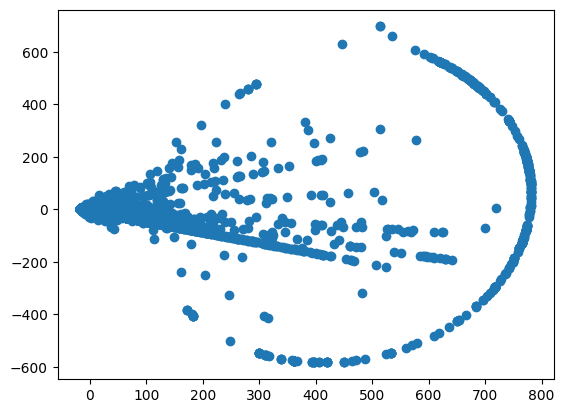

In [ ]:
plt.scatter(X_hyp_pca[:, 0], X_hyp_pca[:, 1])


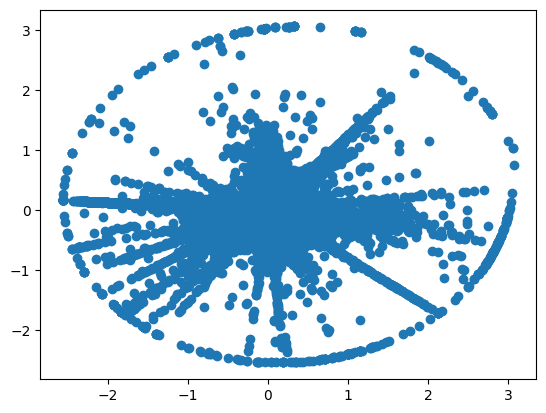

In [ ]:
plt.scatter(
    X_poi_pca[:, 0],
    X_poi_pca[:, 1],
)


## Hyperbolic SVM

In [ ]:
from hyperbolic_learning.hyperbolic_svm.hsvm import LinearHSVM


In [ ]:
hsvm = LinearHSVM()


In [ ]:
# Random labels

y = np.random.binomial(1, 0.5, size=(len(X_embed), 1))

hsvm.fit(X_embed, y)


/home/phil/mambaforge/envs/americangut/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NameError: name 'minkowski_dot' is not defined

In [ ]:
!pip install htools

  Using cached htools-7.7.0-py3-none-any.whl
  Using cached datasketch-1.5.9-py3-none-any.whl (76 kB)
  Using cached fire-0.5.0-py2.py3-none-any.whl
  Using cached multipledispatch-1.0.0-py3-none-any.whl (12 kB)
  Using cached pandas_flavor-0.1.2-py2.py3-none-any.whl (5.7 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached wordninja-2.0.0-py3-none-any.whl
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)


In [ ]:
from hsvm.hsvm import LinearHSVM


ImportError: cannot import name 'Sequence' from 'collections' (/home/phil/mambaforge/envs/americangut/lib/python3.11/collections/__init__.py)